In [1]:
# read hdf5 file and plot the data
import h5py
import numpy as np
import matplotlib.pyplot as plt
import sys

# read the file
datafile_path = "../../data/"
filename = datafile_path + "eye closed2023.11.29_11.05.35.hdf5"

# Data groups and datasets:
data_dict = {
    'AsynchronData': 'AsynchronSignalTypes', 
    'RawData': {
        0: 'AcquisitionTaskDescription',
        1: 'DAQDeviceCapabilities',
        2: 'DAQDeviceDescription',
        3: 'Samples',
        4: 'SessionDescription',
        5: 'SubjectDescription',
    },
    "SavedFeatues": "NumberOfFeatures",     # [0]
    "Version": "Version",                   # [b'0.5']
}

# Save the XML data to a new file
def SaveXML(data, filename):
    # Define the output XML file path
    output_xml_file = filename
    # Write the XML data to a new file
    with open(output_xml_file, 'w') as xml_file:
        xml_file.write(data.decode('UTF-8'))

# data = None
with h5py.File(filename, "r") as f:
    # Print all root level object names (aka keys) 
    # these can be group or dataset names 
    print("Keys: %s" % f.keys())

    # List all the groups in the file
    print("\nGroups in the HDF5 file:")
    print(list(f.keys()))

    # Print all the groups and datasets
    print("\nGroups and datasets in the HDF5 file:")
    for key in f.keys():
        print(key, f[key])
    # Print al the datasets in the RawData group
    print("\nDatasets in the RawData group:")
    print(list(f['RawData'].keys()))

    # Access a specific group
    data_samples = f['RawData']['Samples'][:]
    # # Get all the data under the RawData group
    # data_raw = f['RawData']
    # # Print all the subgroups and datasets in the RawData group
    # print("\nSubgroups and datasets in the RawData group:")
    # for key in data_raw.keys():
    #     # Save the XML data to a new file except for the Samples dataset
    #     if key != 'Samples':
    #         data = data_raw[key][:][0]
    #         SaveXML(data, key + ".xml")


Keys: <KeysViewHDF5 ['AsynchronData', 'RawData', 'SavedFeatues', 'Version']>

Groups in the HDF5 file:
['AsynchronData', 'RawData', 'SavedFeatues', 'Version']

Groups and datasets in the HDF5 file:
AsynchronData <HDF5 group "/AsynchronData" (1 members)>
RawData <HDF5 group "/RawData" (6 members)>
SavedFeatues <HDF5 group "/SavedFeatues" (1 members)>
Version <HDF5 group "/Version" (1 members)>

Datasets in the RawData group:
['AcquisitionTaskDescription', 'DAQDeviceCapabilities', 'DAQDeviceDescription', 'Samples', 'SessionDescription', 'SubjectDescription']


In [2]:
data_samples.shape

(184338, 15)

C:\Users\aiden\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


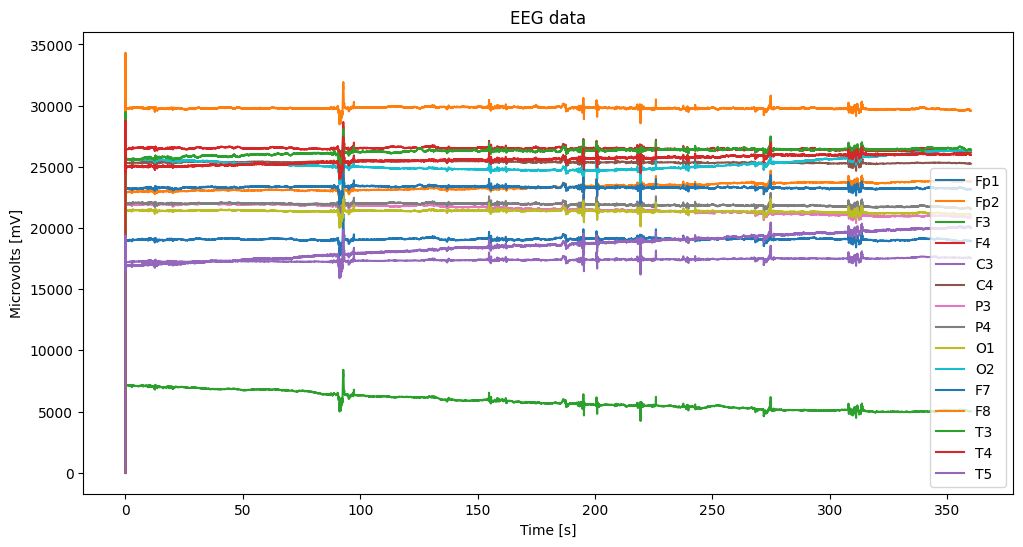

In [3]:
# The data value on x-axis is recorded in 512 Hz, reformat the x-axis to seconds
x = np.arange(0, data_samples.shape[0], 1)
x = x / 512
# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(x, data_samples)
plt.xlabel('Time [s]')
plt.ylabel('Microvolts [mV]')
plt.title('EEG data')
# Add the channel names to the plot
plt.legend(['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz'])
plt.show()


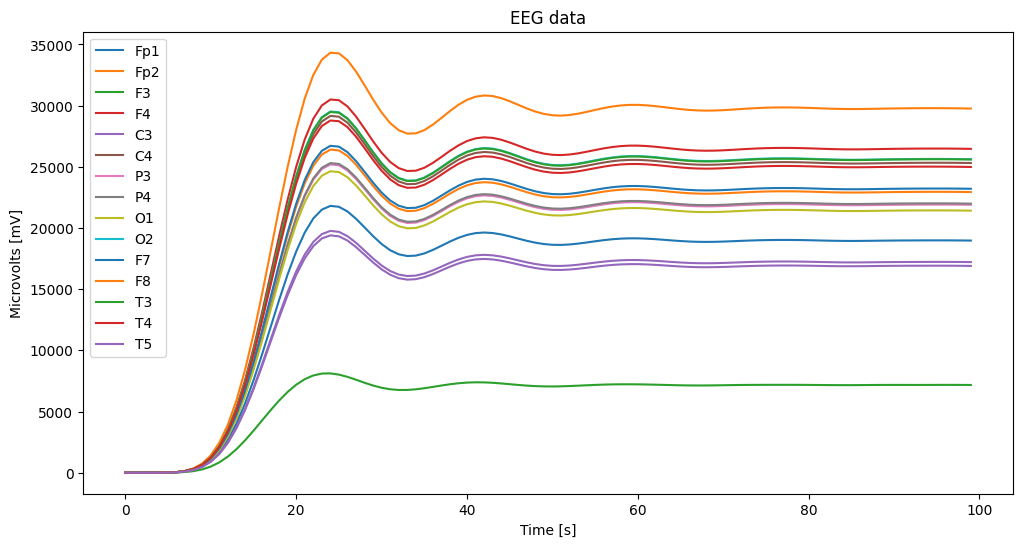

In [4]:
# Plot the first 100 data points
end_idx = 100
plt.figure(figsize=(12, 6))
plt.plot(data_samples[:end_idx])
plt.xlabel('Time [s]')
plt.ylabel('Microvolts [mV]')
plt.title('EEG data')
plt.legend(['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz'])
plt.show()

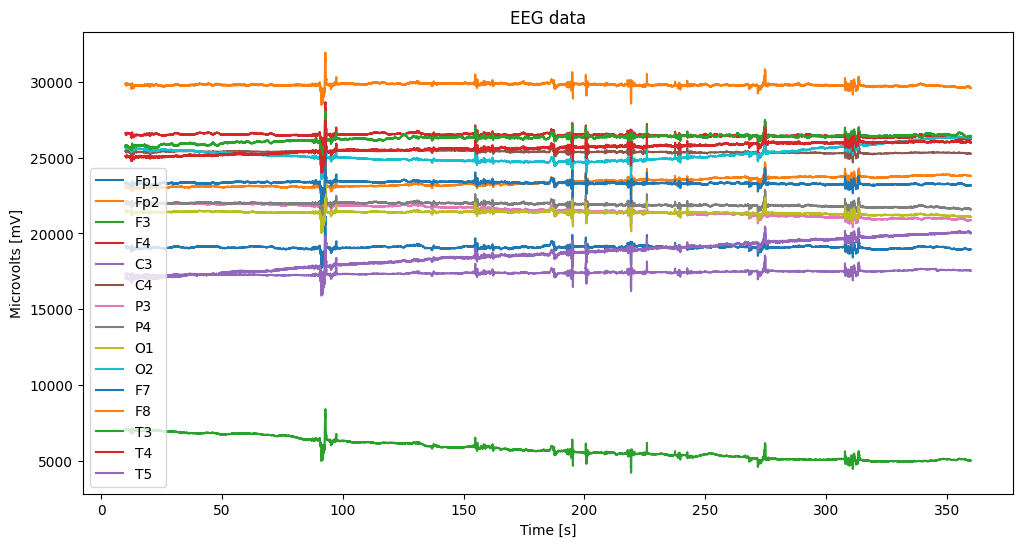

In [5]:
# Discard the data in first 10 seconds
start_idx = 10 * 512
data_time = x[start_idx:]
data_samples = data_samples[start_idx:]
plt.figure(figsize=(12, 6))
plt.plot(data_time, data_samples)
plt.xlabel('Time [s]')
plt.ylabel('Microvolts [mV]')
plt.title('EEG data')
plt.legend(['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz'])
plt.show()

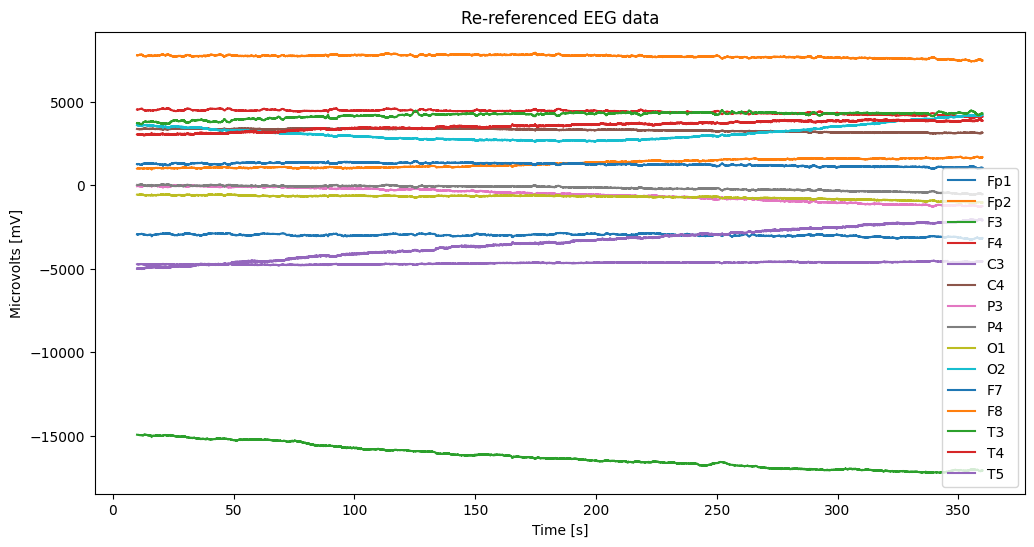

In [6]:
# Apply re-reference to the data
# Re-reference the data to the average of all the channels
data_samples_re = data_samples - np.mean(data_samples, axis=1, keepdims=True)
# Plot the re-referenced data
plt.figure(figsize=(12, 6))
plt.plot(data_time, data_samples_re)
plt.xlabel('Time [s]')
plt.ylabel('Microvolts [mV]')
plt.title('Re-referenced EEG data')
plt.legend(['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz'])
plt.show()

C:\Users\aiden\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


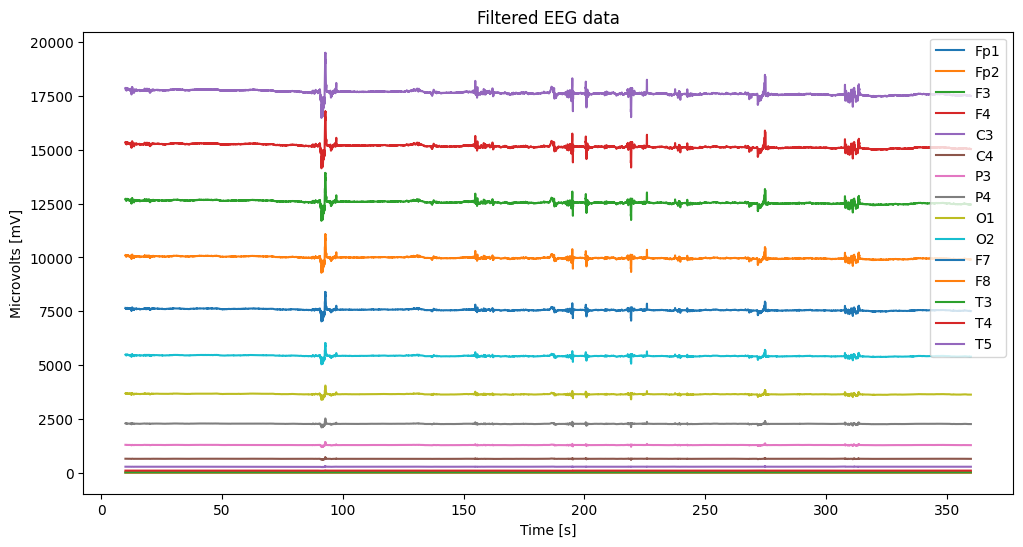

In [7]:
# Apply bandpass filter to the data
from scipy.signal import butter, lfilter
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

# Define the sampling frequency and the cutoff frequencies
fs = 512        # Hz
lowcut = 0.1    # Hz
highcut = 30    # Hz
# Apply the bandpass filter
data_samples_filtered = butter_bandpass_filter(data_samples, lowcut, highcut, fs, order=6)
# Plot the filtered data
plt.figure(figsize=(12, 6))
plt.plot(data_time, data_samples_filtered)
plt.xlabel('Time [s]')
plt.ylabel('Microvolts [mV]')
plt.title('Filtered EEG data')
plt.legend(['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz'])
plt.show()

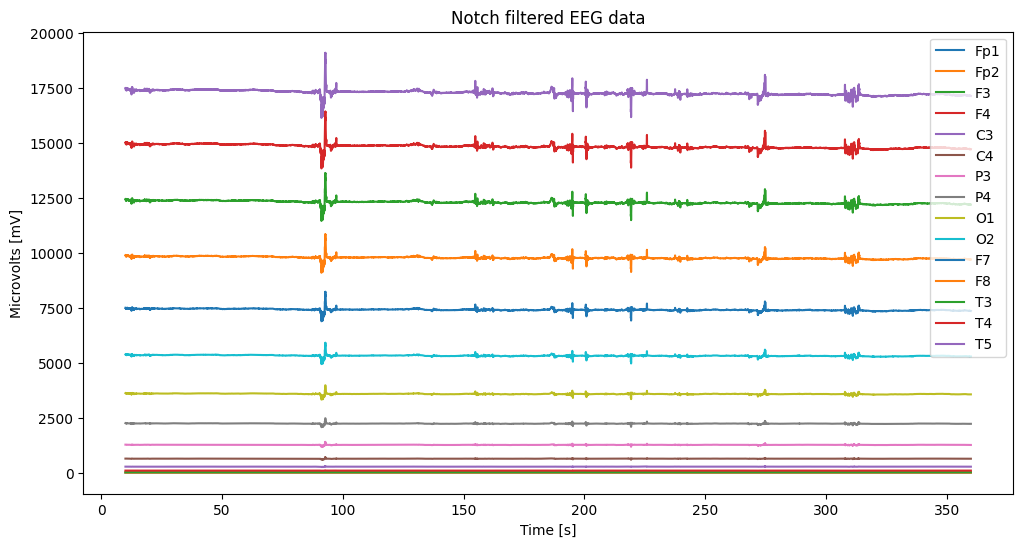

In [8]:
# Apply notch filter to the data
from scipy.signal import iirnotch
def notch_filter(data, fs, f0, Q):
    b, a = iirnotch(f0, Q, fs)
    y = lfilter(b, a, data)
    return y

# Define the notch frequency and quality factor
f0 = 30 # Frequency to be removed from the signal
Q = 30  # Quality factor
# Apply the notch filter
data_samples_filtered_notch = notch_filter(data_samples_filtered, fs, f0, Q)

# Plot the notch filtered data
plt.figure(figsize=(12, 6))
plt.plot(data_time, data_samples_filtered_notch)
plt.xlabel('Time [s]')
plt.ylabel('Microvolts [mV]')
plt.title('Notch filtered EEG data')
plt.legend(['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz'])
plt.show()


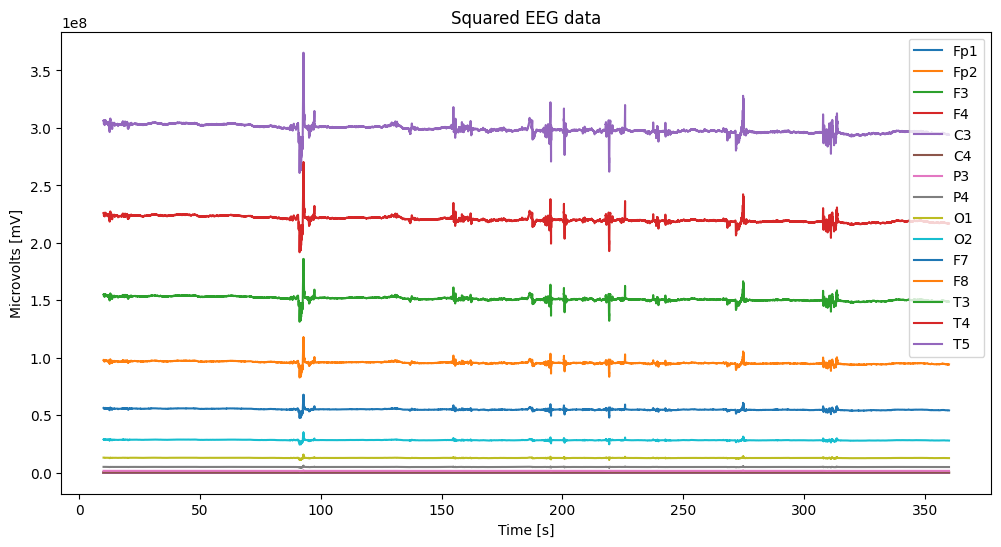

In [9]:
# Square the data
data_samples_squared = data_samples_filtered_notch ** 2
# Plot the squared data
plt.figure(figsize=(12, 6))
plt.plot(data_time, data_samples_squared)
plt.xlabel('Time [s]')
plt.ylabel('Microvolts [mV]')
plt.title('Squared EEG data')
plt.legend(['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz'])
plt.show()

In [10]:
# # Apply moving average filter to the squared data, keep the data shape the same
# def moving_average(data, window_size):
#     # Apply the moving average filter
#     data_ma = np.convolve(data, np.ones(window_size), 'valid') / window_size
#     # return the data to the original shape
#     return data_ma

# window_size = 2
# channels = data_samples_squared.shape[1]
# # test = moving_average(data_samples_squared[0], window_size)
# # print(data_samples_squared[0].shape)
# # print(test.shape)
# data_samples_squared_ma = []
# print(data_samples_squared.shape[1])
# for i in range(channels):
#     data_samples_squared_ma.append(moving_average(data_samples_squared[i], window_size))
# data_samples_squared_ma = np.array(data_samples_squared_ma)
# # Plot the moving average filtered data
# plt.figure(figsize=(12, 6))
# plt.plot(data_samples_squared_ma.T)
# plt.xlabel('Time [s]')
# plt.ylabel('Microvolts [mV]')
# plt.title('Moving average filtered EEG data')
# plt.legend(['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5'])
# plt.show()


C:\Users\aiden\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


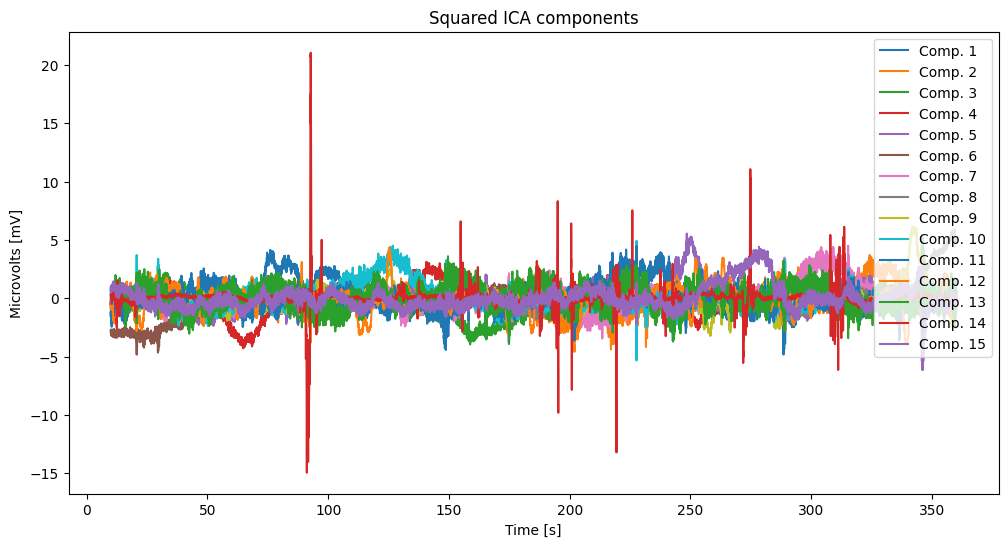

In [14]:
# Apply ICA to the data_samples_squared data
from sklearn.decomposition import FastICA
# Define the number of independent components
n_components = 15
# Apply ICA to the squared data
ica = FastICA(n_components=n_components)
data_samples_ica = ica.fit_transform(data_samples_filtered_notch)
data_samples_ica.shape
# Plot the ICA components
plt.figure(figsize=(12, 6))
plt.plot(data_time, data_samples_ica)
plt.xlabel('Time [s]')
plt.ylabel('Microvolts [mV]')
plt.title('Squared ICA components')
plt.legend(['Comp. '+ str(i+1) for i in range(n_components)])
plt.show()

C:\Users\aiden\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


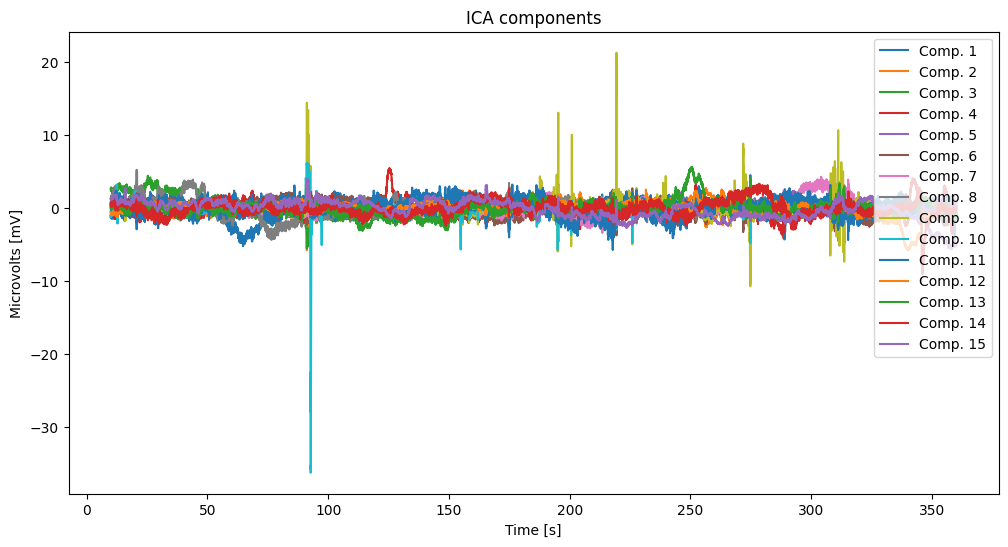

In [12]:
# Apply ICA to the data_samples_squared data
from sklearn.decomposition import FastICA
# Define the number of independent components
n_components = 15
# Apply ICA to the squared data
ica = FastICA(n_components=n_components)
data_samples_ica = ica.fit_transform(data_samples_squared)
data_samples_ica.shape
# Plot the ICA components
plt.figure(figsize=(12, 6))
plt.plot(data_time, data_samples_ica)
plt.xlabel('Time [s]')
plt.ylabel('Microvolts [mV]')
plt.title('ICA components')
plt.legend(['Comp. '+ str(i+1) for i in range(n_components)])
plt.show()

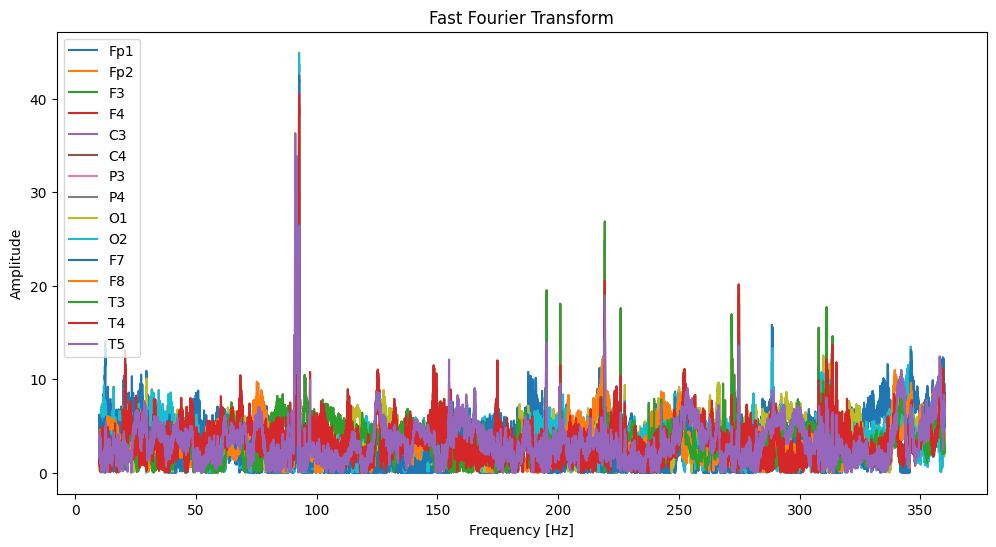

In [13]:
# Apply fast fourier transform to the data
from scipy.fftpack import fft
# Apply the fast fourier transform
data_samples_fft = fft(data_samples_ica)
# Plot the fast fourier transform
plt.figure(figsize=(12, 6))
plt.plot(data_time, np.abs(data_samples_fft))
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude')
plt.title('Fast Fourier Transform')
plt.legend(['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz'])
plt.show()

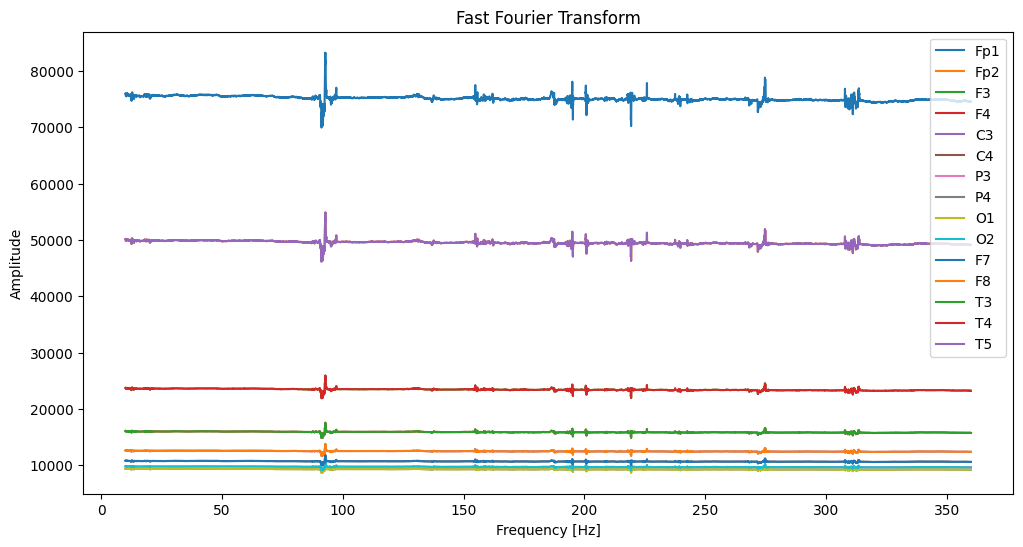

In [15]:
# Apply fast fourier transform to the data
from scipy.fftpack import fft
# Apply the fast fourier transform
data_samples_fft = fft(data_samples_filtered_notch)
# Plot the fast fourier transform
plt.figure(figsize=(12, 6))
plt.plot(data_time, np.abs(data_samples_fft))
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude')
plt.title('Fast Fourier Transform')
plt.legend(['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz'])
plt.show()